# **Business Understanding**

### **Latar Belakang**
Tim marketing meminta untuk membuat cluster/segment customer berdasarkan beberapa kriteria seperti jumlah transaksi, jumlah barang yang dibeli, dan total pengeluaran customer.

### **Tujuan**
Tujuan dari project ini adalah untuk membuat
segment customer. Segment customer ini nantinya akan digunakan oleh
tim marketing untuk memberikan personalized
promotion dan sales treatment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
transaction = pd.read_csv('/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Transaction.csv', sep = ';')

In [3]:
transaction.head(2)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1


In [4]:
# Memilih tabel yang akan digunakan
data = transaction[["TransactionID", "CustomerID", "Qty", "TotalAmount"]]

In [7]:
# Melakukan penggabungan data berdasarkan Customer ID
df = data.groupby('CustomerID').agg({
    'Qty': 'sum',
    'TransactionID': 'count',
    'TotalAmount': 'sum',
}).reset_index()


In [8]:
# Mengganti nama kolom
df = df.rename(columns={'TransactionID' : 'Transaction', 'TotalAmount':'Total Amount'})

In [9]:
df

,CustomerID,Qty,Transaction,Total Amount
0,1,60,17,623300
1,2,57,13,392300
2,3,56,15,446200
3,4,46,10,302500
4,5,27,7,268600
...,...,...,...,...
442,443,59,16,485100
443,444,62,18,577700
444,445,68,18,587200
445,446,42,11,423300


**Keterangan Variabel**

*   Customer ID : No unik customer
*   Qty : Jumlah item yang dibeli
*   Transaction : Jumlah transaksi yang dilakukan customer
*   Total Amount : Total pembelian customer

In [21]:
# Memeriksa missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CustomerID    447 non-null    int64
 1   Qty           447 non-null    int64
 2   Transaction   447 non-null    int64
 3   Total Amount  447 non-null    int64
dtypes: int64(4)
memory usage: 14.1 KB


In [22]:
# Memeriksa duplikasi pada data
duplicate = df.duplicated().sum()
print("Jumlah data duplikat:", duplicate)

Jumlah data duplikat: 0



Berdasarkan output dari `df.info()` dan `df.duplicated()`, dapat disimpulkan bahwa tidak ada nilai yang hilang atau pengamatan yang terduplikasi.





In [10]:
df_clust = df.drop(["CustomerID"], axis = 1)

In [11]:
df_clust

,Qty,Transaction,Total Amount
0,60,17,623300
1,57,13,392300
2,56,15,446200
3,46,10,302500
4,27,7,268600
...,...,...,...
442,59,16,485100
443,62,18,577700
444,68,18,587200
445,42,11,423300


In [12]:
# Melakukan standardisasi data
scale = StandardScaler()
x = scale.fit_transform(df_clust)

Sebelum melakukan analisis lebih lanjut, akan dilakukan standardisasi data terlebih dahulu menggunakan `StandardScaler()`. Standardisasi data dilakukan untuk memastikan bahwa semua variabel memiliki skala yang serupa, sehingga mencegah variabel dengan skala besar mendominasi analisis dan memastikan kontribusi setiap variabel setara.

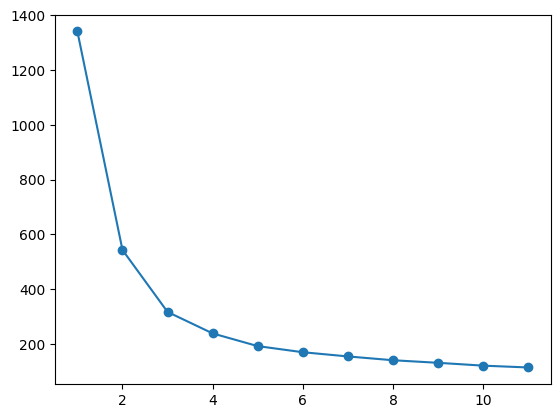

In [13]:
# Elbow Method
wcss = []

for i in range(1,12):
  kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,12), wcss, marker="o")
plt.show()

**Elbow method** adalah sebuah teknik yang digunakan untuk menemukan jumlah klaster yang optimal dalam analisis klaster (clustering). WSS (*Within Sum of Squares*) adalah cara untuk mengukur seberapa dekat titik-titik dalam setiap kelompok dengan pusat kelompoknya

Berdasarkan grafik elbow method di atas, dapat dilihat bahwa nilai *Within Sum of Square* mulai membentuk siku pada titik ke 2. Maka dapat disimpulkan bahwa jumlah klaster yang ditetapkan dalam analisis ini adalah sebanyak 2 klaster

In [14]:
# Membuat model clustering K-Means
model = KMeans(n_clusters = 2, random_state=42)
model.fit(x)

KMeans(n_clusters=2, random_state=42)

In [15]:
# Membuat kolom "Cluster" pada dataframe result
result = df_clust.assign(Cluster = model.labels_)

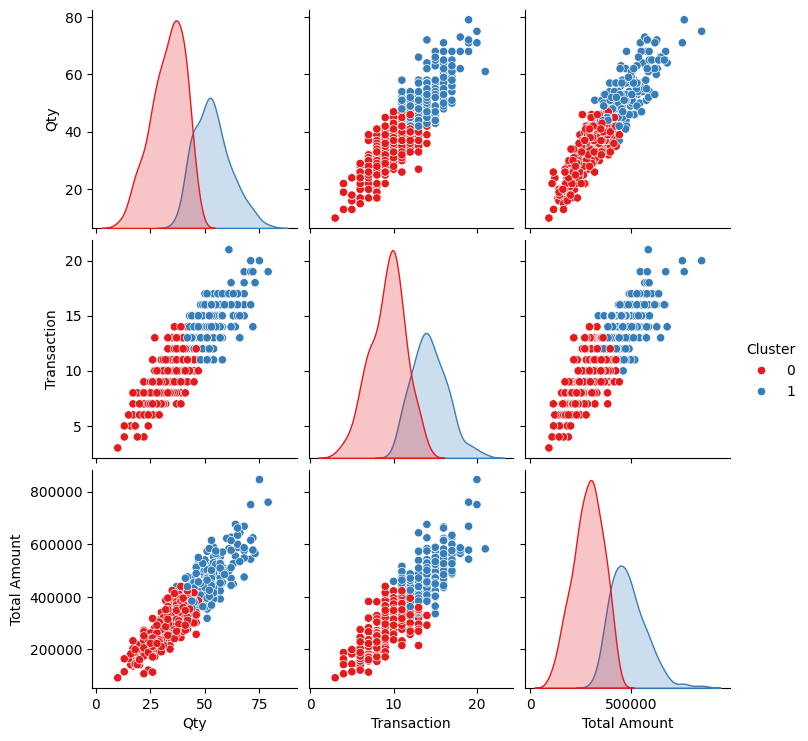

In [16]:
# Visualisasi sebaran cluster
sns.pairplot(result, hue='Cluster', palette ='Set1')
plt.show()

In [17]:
# Evaluasi model clustering K-means menggunakan silhouette score
silhouette_avg = round(silhouette_score(x, model.labels_),1)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5


**Silhouette Score** adalah metrik evaluasi yang digunakan untuk mengukur seberapa baik pengelompokan (klaster) pada data memiliki batas yang jelas atau terpisah satu sama lain. Nilai Silhouette Score berkisar antara -1 hingga 1, di mana nilai yang lebih tinggi menunjukkan pengelompokan yang lebih baik.

Nilai silhouette score sebesar 0.5 menunjukkan bahwa pengelompokan memiliki batas yang jelas dan terpisah satu sama lain, dengan sedikit tumpang tindih antara klaster dan setiap titik data memiliki kedekatan yang baik dengan klaster yang telah ditetapkan.

In [18]:
# Cluster Profiling
profile = round(result.groupby("Cluster").agg({
    'Qty': 'mean',
    'Transaction': 'mean',
    'Total Amount': 'mean'}))
profile

,Qty,Transaction,Total Amount
Cluster,,,
0,33.0,9.0,285677.0
1,53.0,14.0,483064.0


In [19]:
# Menghitung jumlah anggota tiap cluster
jumlah_anggota_klaster = result.groupby('Cluster').size()
pd.DataFrame(jumlah_anggota_klaster, columns=['Jumlah Anggota'])

,Jumlah Anggota
Cluster,
0,273
1,174


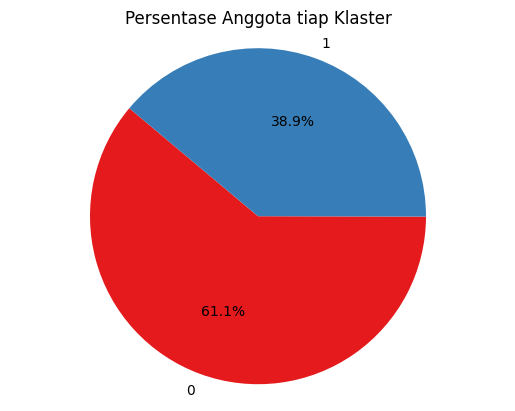

In [28]:
# Mengelompokkan data berdasarkan nilai klaster dan menghitung jumlah anggota di setiap kelompok
jumlah_anggota_klaster = result.groupby('Cluster').size().reset_index(name='Jumlah Anggota')

# Visualisasi jumlah anggota tiap cluster dengan pie chart
plt.title('Persentase Anggota tiap Klaster')
sns.set_palette("Set1")
plt.pie(jumlah_anggota_klaster['Jumlah Anggota'], labels=jumlah_anggota_klaster['Cluster'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

# **Interpretasi Hasil Klaster**

## Berdasarkan hasil analisis cluster yang telah dilakukan, didapatkan beberapa insight sebagai berikut:

### **Segmentasi Pelanggan**
**Klaster 0:**
- Rata-rata customer melakukan transaksi adalah sebanyak 33 transaksi.
- Rata-rata jumlah barang yang dibeli dalam setiap transaksi adalah 9.
- Rata-Rata total pengeluaran yang dilakukan oleh customer adalah Rp. 286,000.

**Klaster 1:**
- Rata-rata customer melakukan transaksi adalah sebanyak 53 transaksi.
- Rata-rata jumlah barang yang dibeli dalam setiap transaksi adalah 14.
- Rata-Rata total pengeluaran yang dilakukan oleh customer adalah Rp. 483,000.

###**Perilaku Konsumen**
Pelanggan dalam Cluster 1 cenderung melakukan transaksi yang lebih besar dan lebih sering dibandingkan dengan pelanggan dalam Cluster 0. Ini mungkin menunjukkan bahwa Cluster 1 adalah pelanggan yang lebih aktif secara finansial atau memiliki kebutuhan yang lebih besar.

### **Strategi Pemasaran**
Cluster 1 dapat menjadi target potensial untuk strategi pemasaran produk atau layanan premium karena mereka cenderung melakukan pembelian dalam jumlah besar.
Cluster 0 mungkin memerlukan pendekatan pemasaran yang berbeda, mungkin fokus pada promosi atau penawaran khusus untuk mendorong peningkatan frekuensi transaksi.